## Description
In this notebook, I use an image (manually generated in GIMP) to generate a simulated MSI dataset with overlapping isotopic envelopes.  
I'll create two images, one with lipids and one with synthetic polymers (spectra generated in IsoSpec).  
Each image also has a certain level of noise signal - random peaks, as well as contaminant molecules.  

Simulation steps:  
1. Generate reference spectra for different regions of the image using manually selected proportions
2. For each pixel, distort the reference proportions of the spectra (depending on the corresponding region); Distort each spectrum by sampling from the multinomial process with the number of molecules given by the corresponding distorted proportion; Combine the distorted spectra; Add a handful of noise peaks amounting for 5% of the total signal to simulate contaminants; Apply a Gaussian filter to the spectra to lower the resolution; Apply a Gaussian distortion to each intensity measurement to simulate electronic noise; Centroid the spectra.  

The result is stored in imzML files.  

## Module & data imports

In [1]:
%matplotlib notebook

In [2]:
import imageio
import numpy as np
import numpy.random as rd 
from masserstein import Spectrum, estimate_proportions
from matplotlib import pyplot as plt
from pyimzml.ImzMLWriter import ImzMLWriter

In [3]:
mask = imageio.imread('SimulationMask.png')

In [4]:
plt.figure()
plt.title('The reference image')
plt.imshow(mask)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

In [5]:
region1 = mask[:,:,0] > 0
region2 = mask[:,:,1] > 0

In [6]:
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.title('Region 1')
plt.imshow(region1)
plt.subplot(122)
plt.title('Region 2')
plt.imshow(region2)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

## Lipid dataset

We'll use two sets of four lipids, in each set we'll use one lipid species with a series of unsaturated bonds.  
I'll choose two series starting from PC(38:0) and PS(38:3), giving a lot of overlapping envelopes.  

In [7]:
PC_38_0 = 'C46H92NO8P'
PC_38_1 = 'C46H90NO8P'
PC_38_2 = 'C46H88NO8P'
PC_38_3 = 'C46H86NO8P'

In [8]:
PS_38_1 = 'C44H84NO10P'
PS_38_3 = 'C44H80NO10P'
PS_38_4 = 'C44H78NO10P'
PS_38_5 = 'C44H76NO10P'
PS_38_6 = 'C44H74NO10P'

In [9]:
formulas = [PC_38_0, PC_38_1, PC_38_2, PC_38_3, PS_38_3, PS_38_4, PS_38_5, PS_38_6]
# formulas = [PC_38_0, PC_38_1, PC_38_2, PC_38_3, PS_38_4]
spectra = [Spectrum(f, adduct='K', threshold=0.001) for f in formulas]
for s in spectra:
    s.normalize()

In [10]:
plt.figure()
plt.title('All input spectra')
Spectrum.plot_all(spectra)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

In [11]:
plt.figure()
Spectrum.plot_all([spectra[2], spectra[4]])

<IPython.core.display.Javascript object>

This is probably too difficult...

Set the proportions for the regions.  
We should probably make some lipids disappear in some regions to make them distinguishable.  

In [12]:
region1_proportions = np.array([0.29, 0.1, 0.05, 0.01, 0.1, 0.2, 0.15, 0.1])
region2_proportions = np.array([0.09, 0.15, 0.15, 0.11, 0.3, 0.1, 0.05, 0.05])
background_proportions = np.array([0.2, 0.8, 0, 0, 0, 0, 0, 0])

In [13]:
plt.figure()
plt.subplot(211)
plt.title('Region 1 reference spectrum')
Spectrum.plot_all([s*p for s,p in zip(spectra, region1_proportions)])
plt.subplot(212)
plt.title('Region 2 reference spectrum')
Spectrum.plot_all([s*p for s,p in zip(spectra, region2_proportions)])
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

In [14]:
region1_reference = Spectrum()
region2_reference = Spectrum()
for p1, p2, s in zip(region1_proportions, region2_proportions, spectra):
    region1_reference += p1*s
    region2_reference += p2*s

Generate an example distorted spectrum from Region 1:

In [15]:
dirichlet_scaling_factor = 2000  # to lower the variance of proportions
# maybe use multidimentional gamma instead?

In [16]:
noise_proportion = 0.05
nb_of_noise_peaks = 10
nb_of_molecules = 1e03

In [17]:
mass_axis = np.arange(846, 863, 0.01)

In [18]:
props = rd.dirichlet(region1_proportions*dirichlet_scaling_factor)

In [19]:
example_spectrum = Spectrum()
for s,p in zip(spectra, props):
    s = Spectrum.sample_multinomial(s, p*nb_of_molecules, 1, 0.001)
    example_spectrum += s

In [20]:
sum(y for x,y in example_spectrum.confs)

996.0515387380941

In [21]:
v1 = np.array([y for x,y in region1_reference.confs])
v2 = np.array([y for x,y in example_spectrum.confs])

In [22]:
np.corrcoef(v1, v2)

array([[1.        , 0.99626668],
       [0.99626668, 1.        ]])

In [23]:
example_spectrum.add_chemical_noise(nb_of_noise_peaks, noise_proportion)

In [24]:
example_spectrum.fuzzify_peaks(0.05, 0.01)

In [25]:
example_spectrum = example_spectrum.resample(mass_axis)

In [26]:
plt.figure()
plt.subplot(121)
Spectrum.plot_all([s*p for s,p in zip(spectra, region1_proportions)])
plt.subplot(122)
example_spectrum.plot(profile=True)
plt.show()

<IPython.core.display.Javascript object>

Centroid the spectrum for estimation:

In [27]:
example_spectrum = Spectrum(confs=example_spectrum.centroid(0.2, 0.4)[0])

In [28]:
plt.figure()
plt.subplot(121)
Spectrum.plot_all([s*p for s,p in zip(spectra, region1_proportions)])
plt.subplot(122)
example_spectrum.plot(profile=False)
plt.show()

<IPython.core.display.Javascript object>

Estimate the proportions based on monoisotopic peaks:

In [29]:
mono_peaks = [s.confs[0][0] for s in spectra]
mono_intensities = np.zeros(len(mono_peaks))

In [30]:
for i, p in enumerate(mono_peaks):
    match = np.argmin([np.abs(p - c[0]) for c in example_spectrum.confs])
    mono_intensities[i]  = example_spectrum.confs[match][1]
mono_intensities /= np.sum(mono_intensities)

In [31]:
mono_intensities

array([0.20206062, 0.08989782, 0.12302555, 0.1454213 , 0.12302555,
       0.1454213 , 0.10248644, 0.06866141])

Test the regression:

In [32]:
example_spectrum.normalize()

In [33]:
# reg = estimate_proportions(example_spectrum, spectra, MTD=0.05)  # for centroided
reg = estimate_proportions(example_spectrum, spectra, MTD=0.5)  # for profile

In [34]:
print('True', 'Regressed', 'Monoisotopic')
for t, e1, e2 in zip(props, reg['proportions'], mono_intensities):
    print(round(t, 3), round(e1, 3), round(e2, 3))

True Regressed Monoisotopic
0.289 0.28 0.202
0.099 0.103 0.09
0.051 -0.0 0.123
0.01 -0.0 0.145
0.105 0.138 0.123
0.192 0.184 0.145
0.15 0.142 0.102
0.103 0.114 0.069


Now, go over each pixel and simulate the spectra:

In [35]:
image = np.zeros((mask.shape[0], mask.shape[1], len(mass_axis)))
for i in range(mask.shape[0]):
    if not i % 50:
        print(i)
    for j in range(mask.shape[1]):
        if mask[i,j][0] > 0:
            props = rd.dirichlet(region1_proportions*dirichlet_scaling_factor)
        elif mask[i,j][1] > 0:
            props = rd.dirichlet(region2_proportions*dirichlet_scaling_factor)
        else:
            props = background_proportions
        pixel_spectrum = Spectrum()
        for s,p in zip(spectra, props):
            s = Spectrum.sample_multinomial(s, p*nb_of_molecules, 1, 0.001)
            pixel_spectrum += s
        pixel_spectrum.add_chemical_noise(nb_of_noise_peaks, noise_proportion)
        pixel_spectrum.fuzzify_peaks(0.05, 0.01)
        pixel_spectrum = pixel_spectrum.resample(mass_axis)
        image[i,j,:] = [y for x,y in pixel_spectrum.confs]

0


Save the image in profile mode in imzML:

In [36]:
with ImzMLWriter('lipid_MSI_profile_mode.imzML') as writer:
    for i in range(mask.shape[0]):
        if not i % 50:
            print(i)
        for j in range(mask.shape[1]):
            writer.addSpectrum(mass_axis, image[i,j,:], (i, j))

0


Centroid the image and save it in imzML:

In [37]:
with ImzMLWriter('lipid_MSI_centroid_mode.imzML') as writer:
    for i in range(mask.shape[0]):
        if not i % 50:
            print(i)
        for j in range(mask.shape[1]):
            S = Spectrum(confs=list(zip(mass_axis, image[i,j,:])))
            peaks, _ = S.centroid(0.25, 0.4)
            mzs = [p[0] for p in peaks]
            intsys = [p[1] for p in peaks]
            writer.addSpectrum(mzs, intsys, (i, j))

0


## Data validation

In [39]:
from pyimzml.ImzMLParser import ImzMLParser

In [40]:
profile_image = ImzMLParser('lipid_MSI_profile_mode.imzML')
centroid_image = ImzMLParser('lipid_MSI_centroid_mode.imzML')

In [41]:
profile_ion_image = np.zeros(mask.shape[:2])
centroid_ion_image = np.zeros(mask.shape[:2])

In [42]:
peak_to_plot = 856.626  # PC_38_0
# peak_to_plot = 852.525    # PC_38_2 and PS_38_3
peak_to_plot = 850.53    # PC_38_3 and PS_38_4

In [43]:
for i, (x,y,z) in enumerate(profile_image.coordinates):
    mz, intsy = profile_image.getspectrum(i)
    mz = np.array(mz)
    peak_id = np.argmin(np.abs(mz-peak_to_plot))
    profile_ion_image[x, y] = intsy[peak_id]
    mz, intsy = centroid_image.getspectrum(i)
    mz = np.array(mz)
    peak_id = np.argmin(np.abs(mz-peak_to_plot))
    centroid_ion_image[x, y] = intsy[peak_id]

<IPython.core.display.Javascript object>


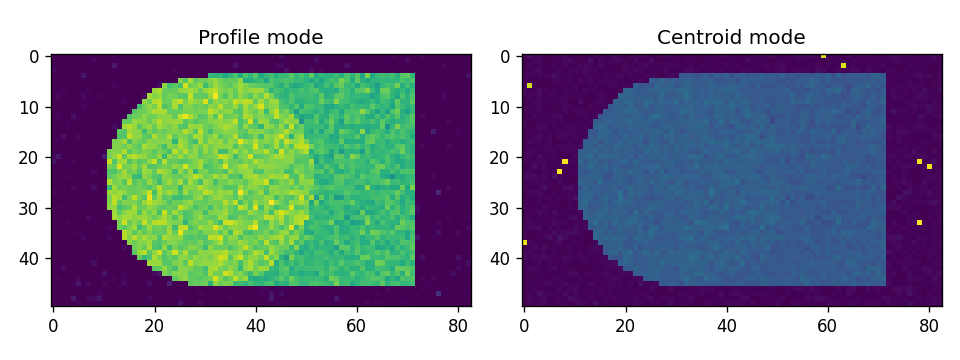

In [44]:
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.title('Profile mode')
plt.imshow(profile_ion_image)
plt.subplot(122)
plt.title('Centroid mode')
plt.imshow(centroid_ion_image)
plt.tight_layout()
plt.show()